In [2]:
import sys
print(sys.version)
!jupyter kernelspec list
import pdb


3.9.16 (main, Jan 11 2023, 10:02:19) 
[Clang 14.0.6 ]
Available kernels:
  python3    /Users/dijiang/opt/anaconda3/share/jupyter/kernels/python3


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# Here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os  # use OS dependent functions like reading or writing files
import re  # regular expressions in Python for searching patterns

import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch.nn as nn  # base class for all neural network modules in PyTorch
from glob import glob  # find all the pathnames matching a specified pattern according to the rules used by the Unix shell
from matplotlib import pyplot as plt # plot libary
import collections # build-in types
from tqdm import tqdm # provides a progress bar for loops and iterators
from itertools import chain # provides iterations 
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction # Natural Language Toolkit (nltk)


/Users/dijiang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Config

In [4]:
class Config:
    train_test_ratio = 0.9 # the proportion of data that will be used for training versus testing
    E = 128
    V = 128
    L = None
    N = None
    # use the content of the decoder's first dimension (=V) as three transformer decoder's first part of input
    # channel: AWGN
    sigma = 0.1  #standard deviation of the Additive White Gaussian Noise (AWGN)
    loss_lambda = 1 # a weighting factor for the loss function
    clipping_max = 1.  # a threshold for clipping the gradients during training
    num_steps = 40 # number of steps for the training process
CONFIG = Config()

# Preprocess

In [42]:
# # !tar -zxvf ./europarl.tgz >/dev/null 2>&1
# # print('Conpression Finished')
txt_list = glob('txt/en/*')
file_cnt = 0
text = []  # corpus‘ split sentences


# # find characters ',.!?', if its previous character is a space, return true
def no_space(char, prev_char):
    return char in set(',.!?') and prev_char != ' '

# Process a set of text files, split them into sentences, and store them in a list. 
# It also checks for empty sentences, and splits sentences that are too long (greater 30 words).
for txt_file in tqdm(txt_list):
    if file_cnt % 1000 == 999:
        print(f'processed{file_cnt}text')
    unprocessed_text = open(txt_file, 'r').read().replace('\xa0', ' ')
    splitted_text = re.split(r'\n|<.*>|\.|!|\?', unprocessed_text)
    i = 0
    while i <= len(splitted_text) - 1:
        if splitted_text[i] == '' or splitted_text[i] == ' ':
            del splitted_text[i]
            continue
                
        if len(splitted_text[i]) > 30:
            space_cnt = 0
            j = 0
            while j <= len(splitted_text[i]) - 1:
                if splitted_text[i][j] == ' ':
                    space_cnt += 1
                j += 1
                if space_cnt == 30:
                    splitted_text.append(splitted_text[i][:j - 1])
                    splitted_text[i] = splitted_text[i][j:]
                    j = 0
                    space_cnt = 0
        i += 1
    text += splitted_text

# # # use 10% of overall text
text = text[:int(len(text) / 10)]
    
# # create corpus in txt
train_txt = open('./corpus_train.txt', 'w')
val_txt = open('./corpus_val.txt', 'w')

train_len = int(len(text) * CONFIG.train_test_ratio) # 90% of corpus is used for training
# process a list of sentences and write them to a file, while also preserving the integrity 
# of the punctuation marks in the sentences by adding a space before certain punctuation marks
for sentence in tqdm(text[:train_len]):
    out = [' ' + char if j > 0 and no_space(char, sentence[j - 1]) else char
        for j, char in enumerate(sentence)]
    train_txt.write((''.join(out)).strip() + '\n')

# like the previous for loop, here process the remaining 10% of text in a different file (testing)
for sentence in tqdm(text[train_len:]):
    out = [' ' + char if j > 0 and no_space(char, sentence[j - 1]) else char
        for j, char in enumerate(sentence)]
    val_txt.write((''.join(out)).strip() + '\n')

100%|█████████████████████████████████████████████████████| 30418/30418 [00:01<00:00, 27875.45it/s]


In [34]:
## commandline
#!pip install subword-nmt
#!subword-nmt learn-bpe -s 30000 < ./corpus_train.txt > ./corpus_train.bpe
#!subword-nmt apply-bpe -c ./corpus_train.bpe < ./corpus_train.txt > ./corpus_train_split.txt
#!subword-nmt apply-bpe -c ./corpus_train.bpe < ./corpus_val.txt > ./corpus_val_split.txt
#!subword-nmt get-vocab --input ./corpus_train_split.txt --output ./corpus_train_vocab.txt

# vocab

In [6]:
class Vocab:  
#   text vocabulary
    # __init__ sorts the tokens by frequency in descending order, and assigns an index to each token
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None): 
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = tokens
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],  # A list of tokens sorted by frequency
                                   reverse=True)
        # Unknown tokens have an index of 0
        self.idx_to_token = ['<unk>'] + reserved_tokens  # List, idx corresponds to the position of token
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self): # returns the length of the vocabulary
        return len(self.idx_to_token)

    def __getitem__(self, tokens): # returns the index of a given token
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices): # returns the token corresponding to a given index
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Unknown tokens have an index of 0
        return 0

    @property
    def token_freqs(self): # returns the list of token frequencies that was sorted in descending order during initialization of the Vocab class.
        return self._token_freqs

def count_corpus(tokens):  
    """Count the frequency of words"""
    # The tokens here are 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flattens a list of tokens into a list
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [7]:
vocab_list = open('./corpus_train_vocab.txt').readlines() 
vocab_dict = {}  # create an empty dictionary
for key_value_pair in vocab_list:
    key_value_pair = key_value_pair.strip().split()
    vocab_dict[key_value_pair[0]] = int(key_value_pair[1]) # in the vocabulary list, key is token and value is the frequency
source_vocab = Vocab(collections.Counter(vocab_dict), reserved_tokens=['<pad>', '<eos>', '<bos>'])

# dataset

In [18]:
train_corpus = open('./corpus_train_split.txt', 'r').readlines()  # the special "\n" has not been processed

class EuroParlDataset(torch.utils.data.Dataset):  # define Pytorch data set
    def __init__(self, vocab=source_vocab, corpus=train_corpus):
        self.vocab = vocab
        self.corpus = corpus
        
    def __len__(self):
        return len(self.corpus)
    
    def __getitem__(self, index):
        sentence = self.corpus[index].strip().split() + ['<eos>']
        return self.vocab[sentence], len(sentence)
    
# collate_fn combines a list of samples into a single batc：
# sorts the batch data by the length of the sentence, in descending order;
# extracts the length of the sentences, and converts the sentences into tensors;
# pads the tensors to the maximum length of the sentences in the batch.
def collate_fn(batch_data): 
    batch_data.sort(key=lambda xi: len(xi[0]), reverse=True)
    data_length = [xi[1] for xi in batch_data]
    data = [torch.tensor(xi[0]) for xi in batch_data]
    padded_data = nn.utils.rnn.pad_sequence(data, batch_first=True, padding_value=1)
    return padded_data, torch.tensor(data_length)

# loads the text data from corpus_train_split.txt and converts it into numerical representations using the vocabulary, with the <eos> token appended to each sentence. 
# Then the dataset is loaded in batches of 32, shuffled, and padded to the maximum length of the sentence in each batch.
data_loader = torch.utils.data.DataLoader(dataset=EuroParlDataset(), batch_size=32, shuffle=True, collate_fn=collate_fn)

# pipeline

In [19]:
# The system  uses nn.embedding
# L E V N setup: E=128， V=128

# backbone

In [20]:
torch.set_printoptions(threshold=np.inf)
# MI needs to be masked; mask first and then sample
# decoder needs to be masked
# phase=2 needs chain
class PositionalEncoding(nn.Module):
    """position encoding"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

class MyEmbedding(nn.Module):
    def __init__(self, vocab=source_vocab):
        super(MyEmbedding, self).__init__()
        self.embedding = nn.Embedding(len(vocab), CONFIG.E, padding_idx=vocab['<pad>'])
        
    def forward(self, X):
        return self.embedding(X)
    
class Encoder(nn.Module):
    def __init__(self, vocab=source_vocab):
        super(Encoder, self).__init__()
        self.position_encoding = PositionalEncoding(CONFIG.V, dropout=0.1)
        self.transformer_encoder1 = nn.TransformerEncoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # 别人的参数
                                                              batch_first=True)
        self.transformer_encoder2 = nn.TransformerEncoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # 别人的参数
                                                              batch_first=True)
        self.transformer_encoder3 = nn.TransformerEncoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # 别人的参数
                                                              batch_first=True)
        self.linear1 = nn.Linear(CONFIG.V, 2 * CONFIG.V)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(2 * CONFIG.V, 16)
        self.relu2 = nn.ReLU()
        
    def forward(self, X, valid_lens):
        mask = (torch.arange((X.shape[1]), device=device).unsqueeze(0) >= valid_lens.unsqueeze(1)).to(device)
        X2 = self.position_encoding(X)
        X3 = self.transformer_encoder1(X2, src_key_padding_mask=mask)
        X4 = self.transformer_encoder2(X3, src_key_padding_mask=mask)
        X5 = self.transformer_encoder3(X4, src_key_padding_mask=mask)
        X6 = self.linear1(X5)
        X7 = self.relu1(X6)
        X8 = self.linear2(X7)
        X9 = self.relu2(X8)
        return X9
        
def Channel(X):  # AWGN
    return X + torch.normal(0, CONFIG.sigma, size=X.shape).to(device)
        
class Decoder(nn.Module):
    def __init__(self, vocab=source_vocab):
        super(Decoder, self).__init__()
        # reshape
        self.position_encoding = PositionalEncoding(CONFIG.V, dropout=0.1)
        self.linear1 = nn.Linear(16, 2 * CONFIG.V)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(2 * CONFIG.V, CONFIG.V)
        self.relu2 = nn.ReLU()
        self.transformer_decoder1 = nn.TransformerDecoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # 别人的参数
                                                              batch_first=True)
        self.transformer_decoder2 = nn.TransformerDecoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # 别人的参数
                                                              batch_first=True)
        self.transformer_decoder3 = nn.TransformerDecoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # 别人的参数
                                                              batch_first=True)
        self.linear3 = nn.Linear(CONFIG.V, len(source_vocab))
#         self.softmax = nn.Softmax(dim=2)  # ?
        
    def forward(self, emb_decoder_input, channel_output, origin_len, tgt_mask=None, mode='train'):
        memory_mask = (torch.arange((channel_output.shape[1]), dtype=torch.float32,
                            device=device)[None, :] >= origin_len[:, None]).to(device)
        channel_output = self.linear1(channel_output)
        channel_output = self.relu1(channel_output)
        channel_output = self.linear2(channel_output)
        memory = self.relu2(channel_output)
        emb_decoder_input = self.position_encoding(emb_decoder_input)
        X6 = self.transformer_decoder1(emb_decoder_input, memory, tgt_mask=tgt_mask, memory_key_padding_mask=memory_mask, tgt_key_padding_mask=memory_mask if mode == 'train' else None)
        X7 = self.transformer_decoder2(X6, memory, tgt_mask=tgt_mask, memory_key_padding_mask=memory_mask, tgt_key_padding_mask=memory_mask if mode == 'train' else None)
        X8 = self.transformer_decoder3(X7, memory, tgt_mask=tgt_mask, memory_key_padding_mask=memory_mask, tgt_key_padding_mask=memory_mask if mode == 'train' else None)
        X9 = self.linear3(X8)
        return X9
#         return self.softmax(X9)
    
class DeepSC(nn.Module):
    def __init__(self):
        super(DeepSC, self).__init__()
        self.encoder = Encoder()
        self.channel = Channel
        self.decoder = Decoder()
        
    def forward(self, emb_encoder_input, valid_lens, emb_decoder_input=None, embedding=None, phase=1):  # valid_lens是含<eos>
        '''
        x: (batch_size, N, E)
        '''
        encode_result = self.encoder(emb_encoder_input, valid_lens)
        channel_outputs = self.channel(encode_result)
        if phase == 2:
            mask = (torch.triu(torch.ones(emb_decoder_input.shape[1], emb_decoder_input.shape[1])) == 1).transpose(0, 1)
            mask = (mask.masked_fill(mask == 0, True).masked_fill(mask == 1, False)).to(device)
            return encode_result, self.channel(encode_result), \
                   self.decoder(torch.cat([embedding(torch.full([emb_decoder_input.shape[0], 1], source_vocab['<bos>'], dtype=torch.long, device=device)), 
                                        emb_decoder_input[:, :-1, :]], dim=1).to(device), 
                                channel_outputs,
                                valid_lens, 
                                mask)
        else:
            return encode_result, self.channel(encode_result)

In [21]:
class MI(nn.Module):
    def __init__(self):
        super(MI, self).__init__()
        self.linear1 = nn.Linear(16 * 2, 2 * CONFIG.V)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(2 * CONFIG.V, 2 * CONFIG.V)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(2 * CONFIG.V, 1)
        self.relu3 = nn.ReLU()
        
    def network(self, X, Y):
        return self.relu3(self.linear3(self.relu2(self.linear2(self.relu1(self.linear1(torch.cat([X, Y], dim=1)))))))
        
    def forward(self, X, Y, valid_lens): 
        
        mask = (torch.arange((X.shape[1]), dtype=torch.long,
                            device=X.device)[None, :] >= valid_lens[:, None]).reshape(-1)
        # 把X和Y先reshape，再拿出来
        X = X.reshape(-1, 16)
        Y = Y.reshape(-1, 16)
        
        X = X[mask == False]
        Y = Y[mask == False]
        
        # sample
        sample_size = X.shape[0]
        idx = list(range(sample_size))
        random.shuffle(idx)
        idx = torch.tensor(idx).to(device)
        X = X[idx]
        Y = Y[idx]
        idx_shuffle = list(range(sample_size))
        random.shuffle(idx_shuffle)
        idx_shuffle = torch.tensor(idx_shuffle).to(device)
        shuffle_Y = Y[idx_shuffle]
        
        output_joint = self.network(X, Y)
        output_marginal = self.network(X, shuffle_Y)
        
        return output_joint, output_marginal

# loss

In [22]:

def mi_criterion(x, y):
    max_y = torch.max(y)
    return torch.mean(x) - (max_y + torch.log(torch.mean(torch.exp(y - max_y))))

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    def sequence_mask(self, X, valid_len, value=0):
        """
        在序列中屏蔽不相关的项
        X: (batch_size, maxlen)
        """
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X
    
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = self.sequence_mask(weights, valid_len)
        self.reduction='mean'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [23]:
embedding = MyEmbedding()
embedding.to(device)
model = DeepSC()
model.to(device)
mi_model = MI()
mi_model.to(device)

MI(
  (linear1): Linear(in_features=32, out_features=256, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=256, out_features=1, bias=True)
  (relu3): ReLU()
)

# train

In [24]:
batch_total_loss_list, batch_mi_loss_list = [], []
epoch_total_loss_list, epoch_mi_loss_list = [], []

In [25]:
# valid_lens只有eos 没有bos
def train(model=model, clipping_max=CONFIG.clipping_max, num_steps=CONFIG.num_steps, phase=1):
    
#     def init_weights(m):
#         if type(m) == nn.Linear:
#             nn.init.kaiming_uniform_(m.weight)
    criterion = MaskedSoftmaxCELoss()
    
    
    if phase == 1:
        mi_optimizer = torch.optim.Adam(mi_model.parameters(), lr=5e-5)
        mi_model.apply(init_weights)
        for epoch in range(20):
            running_mi_loss = 0.
            batch_cnt = 0
            batch_num = len(data_loader)
            for index, data in enumerate(tqdm(data_loader), 0):
                # phase == 1
                mi_optimizer.zero_grad()
                inputs, valid_lens = data
                inputs, valid_lens = inputs.to(device), valid_lens.to(device)
                emb_inputs = embedding(inputs)
                encode_outputs, channel_outputs = model(emb_inputs, valid_lens, phase=1)
                x, y = mi_model(encode_outputs, channel_outputs, valid_lens)
                mi_loss = -mi_criterion(x, y)
                mi_loss.backward()
                torch.nn.utils.clip_grad_norm_(mi_model.parameters(), clipping_max)
                mi_optimizer.step()
                running_mi_loss += float(mi_loss.data)
                batch_mi_loss_list.append(float(mi_loss.data))
                if batch_cnt > batch_num / 5:
                    print(f'now batch:{index} in epoch {epoch}')
                    batch_cnt = 0
                    plt.plot(batch_mi_loss_list)
                    plt.title('batch_mi_loss_list')
                    plt.show()
                batch_cnt += 1
                
            
            with torch.no_grad():
                print('===' * 10, 'epoch:', epoch, 'loss:', running_mi_loss)
                epoch_mi_loss_list.append(running_mi_loss)
                plt.plot(epoch_mi_loss_list)
                plt.title('epoch_mi_loss_list')
                plt.show()
            
    else:
        optimizer = torch.optim.Adam(chain(embedding.parameters(), model.parameters()), lr=1e-3)
#         model.apply(init_weights)
        val_bleus = []
        for epoch in range(15):
            running_total_loss, running_mi_loss = 0., 0.  # 初始化loss
            model.train()
            batch_cnt = 0
            batch_num = len(data_loader)
            
            for index, data in enumerate(tqdm(data_loader), 0):
                # phase == 2
                optimizer.zero_grad()
                inputs, valid_lens = data
                inputs, valid_lens = inputs.to(device), valid_lens.to(device)
                emb_inputs = embedding(inputs)
                encode_outputs, channel_outputs, outputs = model(emb_inputs, valid_lens, emb_inputs, embedding, phase=2)

#                 x, y = mi_model(encode_outputs, channel_outputs, valid_lens)
#                 mi_loss = -mi_criterion(x, y)
#                 if batch_cnt % 5000 == 4999:
#                     print(f'sample:{source_vocab.to_tokens(inputs[0, :valid_lens[0], :])}->{source_vocab.to_tokens(outputs[0, :valid_lens[0], :].argmax(dim=1))}')
                transceiver_loss = criterion(outputs, inputs, valid_lens).mean()
#                 total_loss = transceiver_loss + CONFIG.loss_lambda * mi_loss
                total_loss = transceiver_loss
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(chain(embedding.parameters(), model.parameters()), clipping_max)
                optimizer.step()
                running_total_loss += float(total_loss.data)
#                 running_mi_loss += float(mi_loss.data)
                batch_total_loss_list.append(float(total_loss.data))
#                 batch_mi_loss_list.append(float(mi_loss.data))            

                batch_cnt += 1
                if batch_cnt > batch_num / 5:
                    print(f'now batch:{index} in epoch {epoch}')
                    batch_cnt = 0
#                     plt.plot(batch_mi_loss_list)
#                     plt.title('batch_mi_loss_list')
#                     plt.show()
                    plt.plot(batch_total_loss_list)
                    plt.title('batch_total_loss_list')
                    plt.show()

            print('===' * 10, 'epoch:', epoch, 'loss:', running_total_loss)
            try:
                print('train sample:')
                for i in range(5):
                    print(source_vocab.to_tokens(list(inputs[i].cpu().numpy())), '\n->\n', source_vocab.to_tokens(list(outputs[i, 1:].detach().cpu().argmax(dim=1).numpy())))
                
            except:
                pass
            
            epoch_total_loss_list.append(running_total_loss)
#             epoch_mi_loss_list.append(running_mi_loss)
            plt.plot(epoch_total_loss_list)
            plt.title('epoch_total_loss_list')
            plt.show()
#             plt.plot(epoch_mi_loss_list)
#             plt.title('epoch_mi_loss_list')
#             plt.show()
            
            if epoch <= 1 or epoch_total_loss_list[-1] < epoch_total_loss_list[-2]:
                torch.save(model.state_dict(), 'model.pth')
                torch.save(embedding.state_dict(), 'embedding.pth')
    
            with torch.no_grad():
                model.eval()
                bleus = []
                val_corpus = open('./corpus_val_split.txt', 'r').readlines()
                val_data_loader = torch.utils.data.DataLoader(dataset=EuroParlDataset(corpus=val_corpus), batch_size=32, shuffle=True, collate_fn=collate_fn)
                for index, data in enumerate(tqdm(val_data_loader), 0):
                    inputs, valid_lens = data
                    inputs, valid_lens = inputs.to(device), valid_lens.to(device)
                    emb_inputs = embedding(inputs)
                    _, channel_outputs = model(emb_inputs, valid_lens, phase=1)
                    # 解码的第一个词元是<bos>
                    outputs = torch.cat([torch.full([inputs.shape[0], 1], source_vocab['<bos>'], dtype=torch.long, device=device), 
                                         torch.full([inputs.shape[0], num_steps - 1], source_vocab['<pad>'], dtype=torch.long, device=device)], 
                                        dim=1).to(device)
                    # continue_idx标志哪些句子还可以继续生成
                    continue_idx = torch.arange(inputs.shape[0], device=device)
                    num_step = 0
                    while not len(continue_idx) == 0 and num_step < num_steps - 1:
                        emb_outputs = embedding(outputs[continue_idx, :num_step + 1])
                        pred_words = model.decoder(emb_outputs, channel_outputs[continue_idx], valid_lens[continue_idx], mode='validate').argmax(dim=2)[:, -1:]
                        outputs[continue_idx, num_step + 1] = pred_words.squeeze(1)
                        continue_idx = continue_idx[(pred_words != source_vocab['<eos>']).squeeze(1)]
                        num_step += 1
                    for i in range(inputs.shape[0]):
                        bleus.append(sentence_bleu([list(inputs[i].cpu().numpy())], list(outputs[i, 1:].cpu().numpy()), smoothing_function=SmoothingFunction().method1))
                print('val sample:')
                for i in range(5):
                    print(source_vocab.to_tokens(list(inputs[i].cpu().numpy())), '\n->\n', source_vocab.to_tokens(list(outputs[i, 1:].cpu().numpy())))
                print(f'val bleu mean:{sum(bleus) / len(bleus)}')
                val_bleus.append(sum(bleus) / len(bleus))
                plt.plot(val_bleus)
                plt.title('val_bleus')
                plt.show()

 20%|███████████▏                                            | 1711/8555 [44:35<2:22:52,  1.25s/it]

now batch:1711 in epoch 0


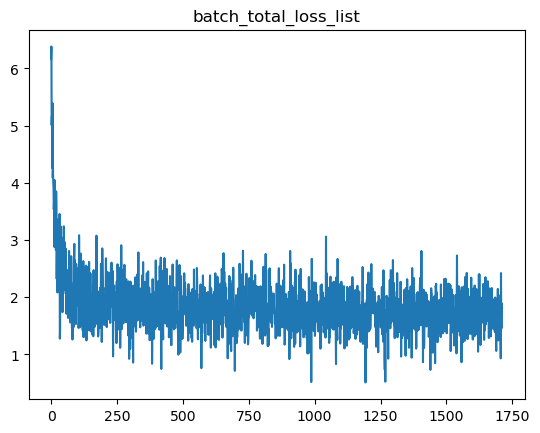

 40%|█████████████████████▌                                | 3423/8555 [1:23:32<1:20:36,  1.06it/s]

now batch:3423 in epoch 0


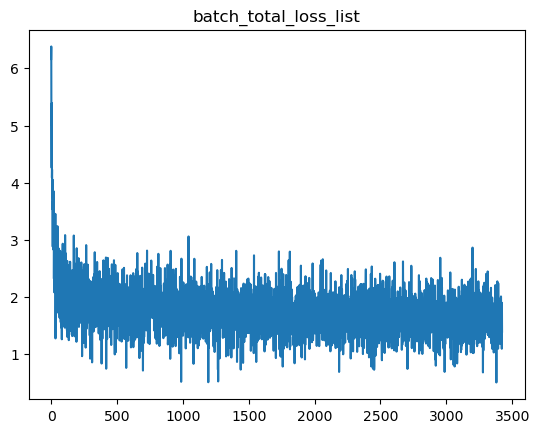

 60%|█████████████████████████████████▌                      | 5135/8555 [1:50:18<52:16,  1.09it/s]

now batch:5135 in epoch 0


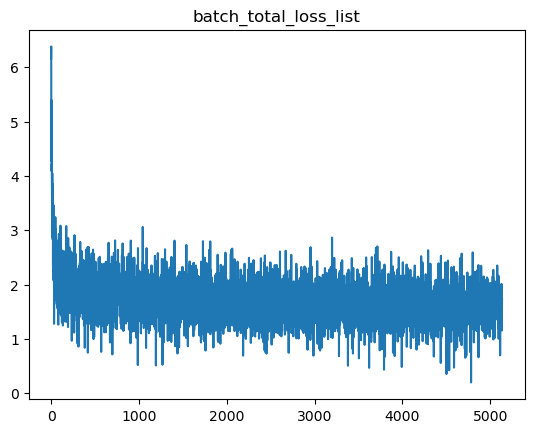

 80%|████████████████████████████████████████████▊           | 6847/8555 [2:17:25<24:14,  1.17it/s]

now batch:6847 in epoch 0


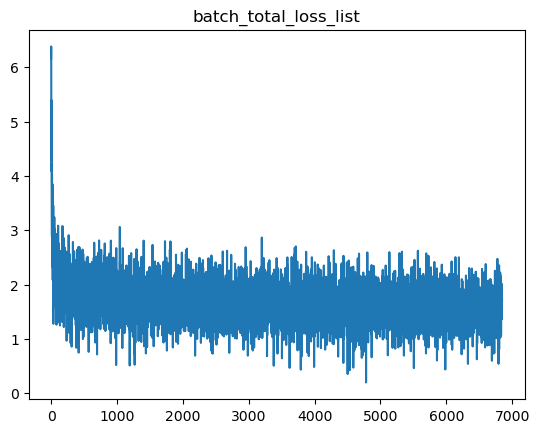

100%|████████████████████████████████████████████████████████| 8555/8555 [2:43:31<00:00,  1.15s/it]

============================== epoch: 0 loss: 14031.044894188643
train sample:
['Finally', ',', 'we', 'should', 'not', 'hesitate', 'to', 'use', 'an', 'instrument', 'we', 'have', 'at', 'our', 'disposal', ',', 'namely', 'Article', '7', ',', 'in', 'cases', 'where', 'a', 'Member', 'State', 'or', 'a', 'Member', 'State', 'government', 'fails', 'to', '<eos>'] 
->
 [',', 'the', 'must', 'not', 'be', 'to', 'be', 'the', 'economic', 'for', 'are', 'a', 'the', 'own', '<eos>', 'but', 'the', '3', 'of', 'but', 'the', 'of', 'the', 'number', 'State', 'is', 'the', 'number', 'State', '<eos>', '<eos>', 'to', '<eos>']
['Madam', 'President', ',', 'as', 'a', 'parliamentarian', 'I', 'feel', 'myself', 'to', 'be', 'represented', 'by', 'the', 'President', 'of', 'this', 'House', 'above', 'all', 'others', ',', 'and', 'so', 'it', 'is', 'to', 'you', 'that', 'I', 'wish', 'to', '<eos>', '<pad>'] 
->
 ['President', ',', 'I', 'I', 'result', 'of', 'am', 'that', ',', 'be', 'able', 'by', 'the', 'European', 'of', 'the', 'Hous

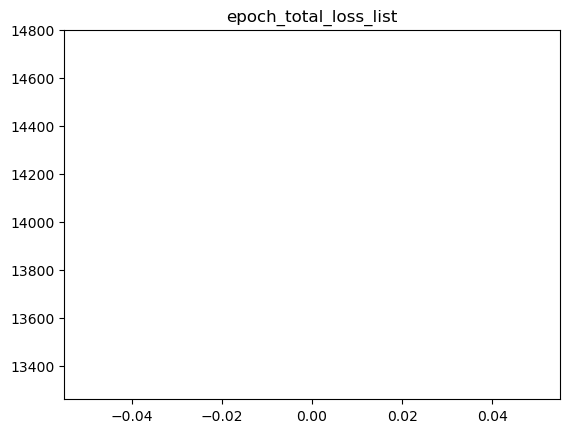

100%|████████████████████████████████████████████████████████████| 949/949 [34:57<00:00,  2.21s/it]

val sample:
['Also', ',', 'when', 'you', 'are', 'chairing', 'a', 'meeting', ',', 'wait', 'a', 'moment', 'before', 'giving', 'the', 'floor', 'to', 'the', 'next', 'speaker', 'so', 'that', 'the', 'interpreters', 'can', 'finish', 'the', 'speech', 'and', 'change', 'to', '<eos>'] 
->
 ['The', 'Commission', 'is', 'not', 'only', 'one', 'of', 'the', 'European', 'Parliament', ',', 'but', 'also', 'the', 'Commission', ',', 'but', 'also', 'the', 'Council', ',', 'but', 'also', 'to', 'ensure', 'that', 'the', 'Commission', 'will', 'be', 'able', 'to', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [26]:
train(phase=2)

  0%|▏                                                           | 2/949 [00:11<1:26:49,  5.50s/it]

val sample:
['To', 'an', 'extent', ',', 'that', 'is', 'what', 'has', 'been', 'decide@@', 'd:', 'a', 'reflection', ',', 'not', 'behind', 'closed', 'doors', ',', 'in', 'secret', ',', 'but', 'a', 'reflec@@', 'tion-@@', 'debate', ',', 'a', 'reflec@@', 'tion-@@', 'dialogue', 'with', 'the', 'citizens', 'on', 'the', 'path', 'of', '<eos>'] 
->
 ['The', 'Commission', 'is', 'not', 'only', 'one', 'of', 'the', 'European', 'Parliament', ',', 'but', 'also', 'the', 'Commission', ',', 'but', 'also', 'the', 'Council', ',', 'but', 'also', 'to', 'ensure', 'that', 'the', 'Commission', 'will', 'be', 'able', 'to', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['protection', 'from', 'this', 'persecution', ',', 'from', 'those', 'who', 'have', ',', 'for', 'example', ',', 'entered', 'a', 'country', 'illegally', 'or', 'who', 'have', 'smuggled', 'people', 'in', ',', 'or', 'from', 'those', 'who', 'have', 'been', 'smuggled', 'in', 'against', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<p

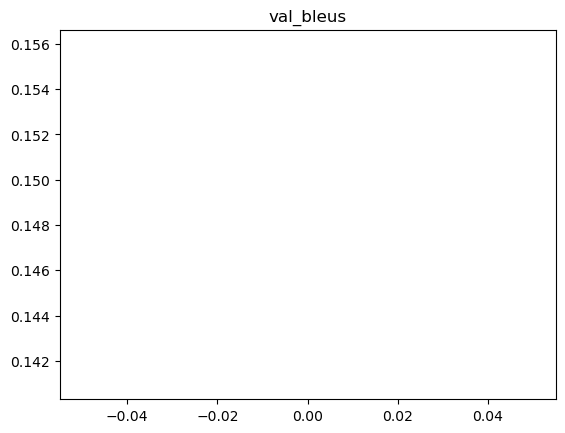

In [27]:
num_steps = 40
val_bleus = []
with torch.no_grad():
    model.eval()
    bleus = []
    val_corpus = open('./corpus_val_split.txt', 'r').readlines()
    val_data_loader = torch.utils.data.DataLoader(dataset=EuroParlDataset(corpus=val_corpus), batch_size=32, shuffle=True, collate_fn=collate_fn)
    for index, data in enumerate(tqdm(val_data_loader), 0):
        inputs, valid_lens = data
        inputs, valid_lens = inputs.to(device), valid_lens.to(device)
        emb_inputs = embedding(inputs)
        _, channel_outputs = model(emb_inputs, valid_lens, phase=1)
        # 解码的第一个词元是<bos>
        outputs = torch.cat([torch.full([inputs.shape[0], 1], source_vocab['<bos>'], dtype=torch.long, device=device), 
                             torch.full([inputs.shape[0], num_steps - 1], source_vocab['<pad>'], dtype=torch.long, device=device)], 
                            dim=1).to(device)
        # continue_idx标志哪些句子还可以继续生成
        continue_idx = torch.arange(inputs.shape[0], device=device)
        num_step = 0
        while not len(continue_idx) == 0 and num_step < num_steps - 1:
            emb_outputs = embedding(outputs[continue_idx, :num_step + 1])
            pred_words = model.decoder(emb_outputs, channel_outputs[continue_idx], valid_lens[continue_idx], mode='validate').argmax(dim=2)[:, -1:]
            outputs[continue_idx, num_step + 1] = pred_words.squeeze(1)
            continue_idx = continue_idx[(pred_words != source_vocab['<eos>']).squeeze(1)]
            num_step += 1
        for i in range(inputs.shape[0]):
            bleus.append(sentence_bleu([list(inputs[i].cpu().numpy())], list(outputs[i, 1:].cpu().numpy()), smoothing_function=SmoothingFunction().method1))
        if index == 2:
            break
    print('val sample:')
    for i in range(5):
        print(source_vocab.to_tokens(list(inputs[i].cpu().numpy())), '\n->\n', source_vocab.to_tokens(list(outputs[i, 1:].cpu().numpy())))
    print(f'val bleu mean:{sum(bleus) / len(bleus)}')
    val_bleus.append(sum(bleus) / len(bleus))
    plt.plot(val_bleus)
    plt.title('val_bleus')
    plt.show()